# Predição de falhas utilizando Self-Training Classifier

A seguir, a separação do script:

**1.** Pré-processamento

**2.** Aplicação de modelos

**3.** Random Forest

**4.** Self-Training

**5.** Arquivo Final

**6.** Conclusões

In [27]:
# Bibliotecas

import pandas as pd
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [28]:
# Bibliotecas

from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.metrics import f1_score, classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.svm import SVC

# 1. Pré-processamento

**Transformação da coluna failure_type**

A coluna foi convertida para um valor binário devido à baixa quantidade de tipos de falha encontrados nos dados e, fazendo essa mudança, o conjunto se torna mais robusto.

1 - Máquina falhou

0 - Máquina não falhou

**Retirada da coluna product_id**

A coluna product_id foi retirada por se tratar da mesma informação da coluna type, porém, com dados organizados de outra forma. A coluna type passará pelo processo de Labelencoder e, havendo esta informação disponível, o uso da coluna product_id se torna dispensável.

In [29]:
# Carregando dados

df_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Cientista de Dados/Pasta GIT/manutencao_preditiva_treino.csv')
teste = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Cientista de Dados/Pasta GIT/manutencao_preditiva_teste.csv')

# Tranformação da coluna 'failure_type'

df_data['failure_type'] = df_data['failure_type'].astype(str)
df_data['failure_type'] = [0 if column == 'No Failure' else 1 for column in df_data['failure_type']]

# Exclusão da coluna 'product_id'

df_data_dropped = df_data.drop(columns=['product_id', 'udi'])
teste_dropped = teste.drop(columns=['product_id', 'udi'])

**Contagem de dados**

Na análise exploratória, ficou claro que os dados estão desbalanceados. Por isso, é importante saber a quantidade de cada variável para realizar ou não o balanceamento.

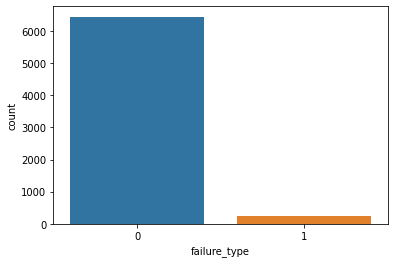

In [30]:
# Gráfico com contagem de da coluna failure_type

sns.countplot(x=df_data_dropped['failure_type'])
plt.show()

In [31]:
# Contagem exata da coluna failure_type

df_data_dropped['failure_type'].value_counts()

0    6435
1     232
Name: failure_type, dtype: int64

**Separar os dados em treino e teste**

Antes de aplicar o modelo semi-supervisionado, que trará o resultado, será utilizado um supervisionado. Para isso, é necessário particionar os dados entre treino e teste. Aqui, 25% do dataset foi separado para compor os dados de teste.

In [32]:
# Variáveis de treino e teste

X = df_data_dropped.iloc[:,:-1] 
y = df_data_dropped.iloc[:,-1] 

X_pre_uln = teste_dropped
X_pre_uln['failure_type'] = -1
X_unlabeled = X_pre_uln.drop(columns=['failure_type'])
y_unlabeled = X_pre_uln['failure_type']

In [33]:
# Particionando os dados em teste e treino

X_train, X_test, y_train, y_test = train_test_split(X,y , random_state=42, test_size=0.25, shuffle=True)

**Dados balanceados**

Para obter melhores resultados, foi feito o balanceamento dos dados, respeitando uma porção de 1:100. Isso diminui a quantidade de dados disponíveis para treino, porém, melhorou o desempenho do modelo.

In [34]:
# Balanceando os dados 

undersample = RandomUnderSampler(sampling_strategy={1:180, 0:1800})
X_train, y_train = undersample.fit_resample(X_train, y_train)
print("Depois do balenceamento:", Counter(y_train))

Depois do balenceamento: Counter({0: 1800, 1: 180})


**LabelEncoder**

A função LabelEncoder transforma as palavras em dados numéricos, sua aplicação é necessária, pois, os valores dessas colunas transformadas são categóricos, por isso, em seu formato original, não poderiam ser interpretados pelo modelo.

In [35]:
# Aplicação do LabelEncoder

le = LabelEncoder()
X_train['type'] = le.fit_transform(X_train['type'])
X_test['type'] = le.fit_transform(X_test['type'])
X_unlabeled['type'] = le.fit_transform(X_unlabeled['type'])

**Variáveis Dummies**

Essa é uma técnica que atribui um vetor binário a dados que são para categorização. Sem esse processo, o modelo poderia interpretar com pesos diferentes de acordo com os valores da coluna. A coluna que compartilha dessa característica é a type, e nela, foi aplicada a função get_dummies da biblioteca Pandas.

In [36]:
# Definindo função que irá gerar os vetores

def dummy(df):
  dummy_df = pd.get_dummies(df['type'], prefix='type')
  df = pd.concat([df, dummy_df], axis=1)
  df_dropped = df.drop(columns=['type_2'])
  return df_dropped


In [37]:
# Aplicando a função

X_train = dummy(X_train)
X_test = dummy(X_test)
X_unlabeled = dummy(X_unlabeled)

# 2. Aplicação de modelos

Para aplicação do modelo final de classificação semi-supervisionado, deve ser aplicado primeiro um modelo supervisionado nos dados. Assim serão aplicados alguns para que, com base em suas métricas, seja possível escolher o que melhor se encaixa no objetivo do modelo.

In [40]:
# Aplicando pipelines de modelos para diferentes classificadores

pipeline_lr = Pipeline([('lr_classifier',LogisticRegression())])
pipeline_dt = Pipeline([('dt_classifier',DecisionTreeClassifier())])
pipeline_gbcl = Pipeline([('gbcl_classifier',GradientBoostingClassifier())])
pipeline_rf = Pipeline([('rf_classifier',RandomForestClassifier())])
pipeline_knn = Pipeline([('knn_classifier',KNeighborsClassifier())])

In [41]:
# Função de predição e matriz de confusão

def predicao(clf):
  clf.fit(X_train,y_train)
  y_pred = clf.predict(X_test)
  cm = confusion_matrix(y_test, y_pred, labels=clf.classes_, normalize='all')
  print('F1 Score:', f1_score(y_test, y_pred))
  print('Matriz de confusão: \n', cm, '\n')

# Definindo modelos

pipeline_lr = Pipeline([('lr_classifier',LogisticRegression())])
pipeline_dt = Pipeline([('dt_classifier',DecisionTreeClassifier())])
pipeline_gbcl = Pipeline([('gbcl_classifier',GradientBoostingClassifier())])
pipeline_rf = Pipeline([('rf_classifier',RandomForestClassifier())])
pipeline_knn = Pipeline([('knn_classifier',KNeighborsClassifier())])

# Aplicando modelos

pipelines = {'Logistic Regression':pipeline_lr, 'Decision Tree':pipeline_dt, 'Gradient Boosting':pipeline_gbcl, 'Random Forest':pipeline_rf, 'KNeighbors':pipeline_knn}
for k, pipe in pipelines.items():
  print(k)
  predicao(pipe)

Logistic Regression
F1 Score: 0.35416666666666663
Matriz de confusão: 
 [[0.95260948 0.01619676]
 [0.0209958  0.01019796]] 

Decision Tree
F1 Score: 0.5390070921985815
Matriz de confusão: 
 [[0.93821236 0.03059388]
 [0.00839832 0.02279544]] 

Gradient Boosting
F1 Score: 0.6
Matriz de confusão: 
 [[0.95380924 0.014997  ]
 [0.01139772 0.01979604]] 

Random Forest
F1 Score: 0.6422018348623854
Matriz de confusão: 
 [[0.95560888 0.01319736]
 [0.01019796 0.0209958 ]] 

KNeighbors
F1 Score: 0.2912621359223301
Matriz de confusão: 
 [[0.94721056 0.02159568]
 [0.02219556 0.0089982 ]] 



# 3. Random Forest

O modelo que apresentou melhor desempenho no F1 Score e na matriz de confusão foi o Random Forest. Este algoritmo é composto por árvores, mais especificamente árvores de decisão, que são selecionadas randomicamente por meio da seleção de amostras do conjunto de dados. Das predições de cada árvore, é tirada a média de votos e, assim, o Random Forest escolhe a melhor solução para o problema.

Uma das vantagens desse algoritmo é que ele evita o problema de overfitting, já que, tirando a média das previsões, e também elimina possíveis vieses. Ele pode trabalhar com valores nulos, o que não é o caso do conjunto de dados desse projeto, porém, é uma característica que o torna diferenciado. Entretanto, o Random Forest tem a desvantagem de ser muito lento devido ao o processo de predição e votação, que é realizado em uma grande quantidade de árvores.

In [42]:
# Aplicando o Random Forest

clf = RandomForestClassifier(n_estimators=100, bootstrap=True, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

**Métricas**

&gt; **Acurácia**

A acurácia é a métrica que diz o quanto o modelo está prevendo corretamente a falha das máquinas. O RandomForest apresentou cerca de 96% de acurácia, entretanto, essa não é a única medida que deve ser observada isoladamente, pois, precisamos saber o quanto o modelo prevê que uma máquina falhou, quando, na verdade, ela não falhou e vice-e-versa.

&gt; **F1 Score**

O F1 Score combina as métricas de recall e precisão, fornecendo um valor balanceado entre as duas, sendo mais assertivo que a acurácia, pois, fornece informações também sobre os falsos positivos e negativos. O valor do F1 Score obtido médio no modelo nos indica que o recall ou a precisão está baixa.

Calculando cada uma separadamente, observa-se que a precisão para a previsão de **não falha** está alta, indicando que a maioria das previsões realmente positivas, foi analisada corretamente. O mesmo se repete para o recall, o qual indica sua eficiência em fazer essa previsão, tendo poucos falsos positivos.

Entretanto, para a variável 1, referente a **falha**, o modelo não se comportou muito bem, com uma precisão que talvez poderia ser comparada com o mesmo que escolher aleatoriamente qual máquina iria falhar, por isso, o modelo tem baixa chance de acertar os que realmente irão falhar. O recall diz que há poucos falsos negativos previstos no modelo, isso quer dizer que, **das máquinas que não falham poucos são classificados com falha**.

In [43]:
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1615
           1       0.62      0.67      0.65        52

    accuracy                           0.98      1667
   macro avg       0.81      0.83      0.82      1667
weighted avg       0.98      0.98      0.98      1667



**Matriz de confusão**

Aqui pode-se verificar graficamente os falsos positivos e falsos negativos do modelo e, com isso, o quanto ele está acertando ou errando em suas previsões.

É possível analisar que **o modelo cumpre bem a função de prever as máquinas que não apresentarão falha**. Então, podemos confiar na previsão das máquinas que não apresentarão defeito.

Por outro lado, ao prever que a máquina irá falhar, o modelo peca em seu resultado. Por isso, sua resposta a respeito dessa categoria **não é confiável**.

Já os que representam os falsos positivos e falsos negativos estão baixos, indicando que há poucos resultados são alarmes falsos.

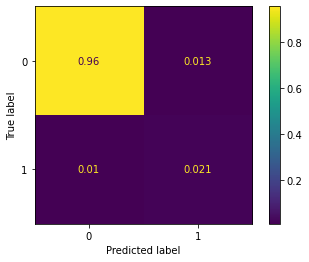

In [44]:
# Matriz de confusão

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_, normalize='all')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()


# 4. Self-Training

Para chegar ao resultado, prever as falhas do data set de treino, será aplicado o Self-Training, modelo semi-supervisionado de classificação, que trabalha com parte dos dados categorizados, e outra não. Utiliza-se a porção categorizada para treinar o modelo supervisionado, e então, prever o resultado dos dados não categorizados.

Durante a implementação do Self-Training, é necessário escolher o grau de probabilidade da previsão ser positiva, aqui usou-se o valor de 0.7. As labels que superam esse grau, são classificadas como pseudo-labels, são combinadas aos dados categorizados para então serem usadas no processo de treino novamente. Esse processo é repetido até que a taxa de probabilidade seja atingida ou não existam mais dados não categorizados restantes.

In [45]:
# Função para concatenar variáveis

def concat(df1, df2, axis):
  df_1 = pd.DataFrame(df1)
  df_2 = pd.DataFrame(df2)
  df_concat = pd.concat([df_1, df_2], axis=axis)
  arr_final = df_concat.values
  return arr_final

In [46]:
# Aplicação da função

X_train_unl = concat(X_train, X_unlabeled, axis=0)
y_train_unl = concat(y_train, y_unlabeled, axis=0)

In [47]:
# Especificando os parâmetros da função SVC

model_svc = SVC(kernel='rbf', 
                probability=True,
                C=1.0,
                gamma='scale',
                random_state=0
               )

In [48]:
# Definição do modelo

self_training_model = SelfTrainingClassifier(base_estimator=model_svc, 
                                             threshold=0.7,
                                             criterion='threshold',
                                             max_iter=100, 
                                             verbose=True
                                            )

In [49]:
# Aplicação do modelo

clf_ST = self_training_model.fit(X_train_unl, y_train_unl)

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


End of iteration 1, added 3305 new labels.
End of iteration 2, added 11 new labels.
End of iteration 3, added 4 new labels.
End of iteration 4, added 1 new labels.


**Métricas**

A exibição do Classification Report mostra que, as indicações feitas no modelo Random Forest se repetiram na aplicação do Self-Training. Para a previsão de não falhas, o modelo se mostrou eficiente, com resultado confiável, precisão e recall altos. Portanto, esse é um resultado em que podemos confiar.

Entretanto, para o valor de falha, o modelo não é assertivo, indicando a presença de falsos negativos, máquinas que não falham e são indicadas com falha.

O F1-Score médio final mostrou um valor satisfatório, porém, não se pode confiar tanto nesse número, pois, olhando as outras métricas, nota-se que os valores estão desbalanceados.

In [50]:
# Classification Report

print(classification_report(y_test, clf_ST.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1615
           1       0.50      0.04      0.07        52

    accuracy                           0.97      1667
   macro avg       0.73      0.52      0.53      1667
weighted avg       0.96      0.97      0.96      1667



/usr/local/lib/python3.9/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelfTrainingClassifier was fitted without feature names
  warnings.warn(


# 5. Arquivo Final

In [51]:
# Salvando arquivo em csv

arq = pd.DataFrame(clf_ST.transduction_[-3333:])
arq.to_csv('predicted.csv')

# 6. Conclusões

A aplicação dos modelos se mostrou eficiente somente para prever as máquinas que não falhariam, sendo pouco confiável para dizer as possíveis falhas. Esse resultado pode ter alguma ligação com a quantidade de dados usada, já que foi necessário realizar seu balanceamento. Essa técnica foi essencial para obter conclusões melhores, pois, rodando experimento com os dados originais, os resultados foram menos satisfatórios.

Para se obter previsões melhores, será necessário reavaliar o pré-processamento dos dados, além da própria escolha de modelos. Outras técnicas, como a aprendizagem não supervisionada, pode ser eficaz para se obter um resultado mais preciso. Entretanto, com a aplicação descrita neste script, foi possível ter uma noção inicial de como os dados se comportam quando submetidos ao processo de aprendizagem de máquina.